In [19]:
import pandas as pd

In [20]:

df = pd.read_csv('sab-bma.csv')


In [21]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTAGATCCCACCTTCAAGAGG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGGAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9735,AGGCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTAC...,AGGCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTAC...
9736,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9737,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTGGTA...
9738,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGAGCACCGCAATTCCCAA...


In [22]:
from tqdm import tqdm


In [23]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [24]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [25]:
import difflib


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [27]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 9740/9740 [00:00<00:00, 99305.80it/s]


[94, 141, 189, 229, 259, 303, 335, 377, 398, 437, 498, 503, 580, 579, 658, 691, 731, 739, 786, 814, 871, 892, 952, 992, 998, 1041, 1065, 1070, 1155, 1228, 1232, 1247, 1305, 1336, 1392, 1376, 1476, 1486, 1490, 1549, 1590, 1625, 1682, 1685, 1775, 1773, 1832, 1790, 1910, 1929, 2002, 1982, 2020, 2068, 2342, 2363, 2334, 2236, 2245, 2214, 2154, 2154, 2089, 2081, 2055, 1952, 1958, 1902, 1886, 1837, 1805, 1776, 1725, 1661, 1639, 1611, 1539, 1534, 1438, 1426, 1403, 1364, 1290, 1259, 1243, 1163, 1117, 1057, 1048, 989, 941, 897, 890, 785, 774, 741, 692, 615, 597, 530, 476, 424, 413, 338, 292, 252, 207, 176, 108, 75]


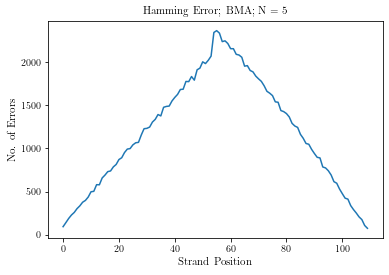

In [28]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-sab-bma-hamming.pdf', bbox_inches='tight')

In [29]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 9740/9740 [00:06<00:00, 1526.02it/s]


In [30]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> TCC 6
 -> TAA 6
CGC ->  6
TAA ->  6
 -> AAC 6
 -> GCT 6
 -> ACA 6
TG -> A 6
TGT ->  6
 -> ATG 6
 -> ATC 6
 -> CCT 6
CTC ->  6
 -> CGT 6
 -> AGT 7
 -> GTA 7
 -> AAT 7
G -> CA 7
 -> GAT 7
G -> AAA 7
A -> TG 7
AC -> G 7
 -> TTT 7
 -> ACC 7
CAG ->  7
 -> TCG 7
GCT ->  7
T -> GC 7
CCT ->  7
 -> GAA 7
TCT ->  8
C -> AAA 8
GAT ->  8
 -> CGG 8
AT -> C 8
 -> GTG 8
GGT ->  8
TAC ->  8
 -> CTT 8
CG -> T 8
T -> AGA 8
TCC ->  8
 -> CCG 8
GC -> A 8
TC -> G 8
 -> CGA 9
 -> CAC 9
CT -> A 9
TT -> C 9
G -> TA 9
 -> AGA 9
 -> GTT 9
 -> GGA 9
CCC ->  9
GCC ->  9
G -> AC 10
 -> GGG 10
CT -> G 10
GT -> C 10
 -> CCA 11
 -> AGG 11
GT -> A 11
 -> CAA 12
 -> GAC 12
C -> AT 12
C -> TG 12
CGT ->  12
GG -> A 12
C -> TT 13
CC -> T 13
TGC ->  14
T -> CA 14
T -> AAA 14
TC -> A 15
G -> AT 15
T -> CG 16
C -> GT 16
C -> AG 17
 -> AAG 17
 -> AAA 18
T -> AG 21
CG -> A 22
A -> GG 22
T -> AC 22
AA ->  24
T -> GA 25
C -> GA 26
T -> CC 27
C -> GG 32
GA ->  38
C -> AA 40
AG ->  40
AT ->  43
AC ->  43
A -> T 47
CA ->  47
A 

 -> A @ 61 6
A ->  @ 10 6
 -> A @ 63 6
T ->  @ 22 6
T -> A @ 68 6
 -> A @ 48 6
C -> T @ 34 6
T -> C @ 45 6
A ->  @ 44 6
 -> CG @ 53 6
C -> T @ 58 6
T -> A @ 6 6
 -> A @ 68 6
 -> G @ 103 6
T -> A @ 60 6
 -> A @ 67 6
 -> A @ 58 6
C -> G @ 87 6
G -> A @ 50 6
T -> A @ 58 6
T -> C @ 48 6
 -> A @ 36 6
G -> A @ 22 6
G -> A @ 61 6
 -> TC @ 55 6
 -> A @ 23 6
C -> A @ 70 6
 -> A @ 2 6
A ->  @ 72 6
C -> A @ 92 6
G -> A @ 28 6
C -> G @ 23 6
 -> A @ 11 6
A ->  @ 110 6
C -> A @ 76 6
C -> A @ 80 6
C -> A @ 87 6
 -> A @ 101 6
T -> A @ 15 6
A ->  @ 71 6
T -> A @ 37 6
T -> A @ 38 6
C -> A @ 67 6
 -> A @ 43 6
C -> G @ 14 6
T -> C @ 77 6
C -> A @ 58 6
A -> G @ 78 6
T -> A @ 48 6
 -> A @ 38 6
A -> G @ 74 6
G -> A @ 32 6
 -> G @ 24 6
T -> C @ 86 6
T -> C @ 87 6
 -> G @ 72 6
T -> A @ 41 6
T -> A @ 40 6
C -> G @ 99 6
A ->  @ 75 6
T ->  @ 26 6
T -> A @ 71 6
 -> A @ 71 6
C -> G @ 86 6
A ->  @ 2 6
 -> G @ 93 6
TT ->  @ 56 6
 -> G @ 32 6
C -> G @ 64 6
T -> G @ 52 6
T -> G @ 71 6
A ->  @ 67 6
C -> G @ 66 6
A ->  @

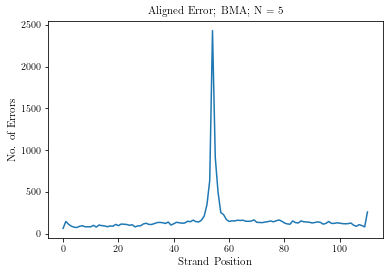

In [31]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-sab-bma-aligned.pdf', bbox_inches='tight')

In [32]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [33]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [34]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 60, 10, 12, 10, 6, 8, 13, 13, 13, 11, 25, 13, 15, 13, 13, 10, 15, 7, 19, 12, 9, 10, 15, 9, 14, 9, 11, 15, 9, 15, 13, 10, 13, 15, 15, 10, 11, 14, 9, 10, 16, 8, 11, 13, 19, 13, 26, 14, 16, 13, 13, 18, 18, 52, 58, 34, 22, 24, 24, 16, 20, 17, 20, 17, 20, 8, 23, 19, 23, 15, 15, 14, 21, 20, 23, 20, 18, 25, 24, 15, 12, 11, 19, 19, 22, 20, 19, 14, 26, 11, 24, 18, 21, 20, 23, 16, 8, 18, 20, 17, 16, 17, 21, 25, 21, 17, 20, 19, 14, 10]
[0, 12, 9, 19, 14, 10, 6, 10, 8, 8, 13, 11, 5, 12, 10, 11, 7, 9, 8, 6, 8, 18, 6, 16, 15, 9, 6, 7, 11, 11, 14, 14, 16, 15, 21, 17, 19, 9, 14, 9, 17, 16, 16, 14, 18, 18, 7, 13, 20, 14, 18, 17, 15, 22, 55, 60, 36, 21, 20, 13, 22, 18, 29, 18, 17, 16, 18, 14, 16, 26, 19, 13, 12, 11, 15, 16, 15, 19, 11, 22, 22, 16, 10, 24, 13, 17, 29, 21, 19, 17, 18, 14, 14, 16, 9, 15, 20, 18, 13, 17, 15, 11, 12, 14, 12, 15, 8, 16, 15, 16, 12]
[0, 17, 15, 5, 12, 6, 13, 12, 13, 5, 12, 9, 14, 11, 13, 6, 12, 18, 6, 8, 6, 14, 17, 7, 5, 10, 9, 13, 4, 18, 16, 7, 11, 12, 9, 13, 14, 11, 14, 

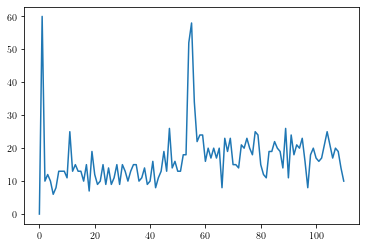

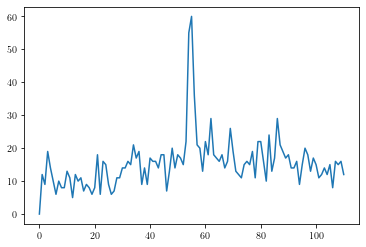

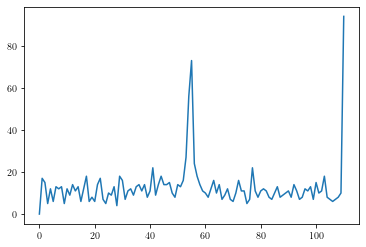

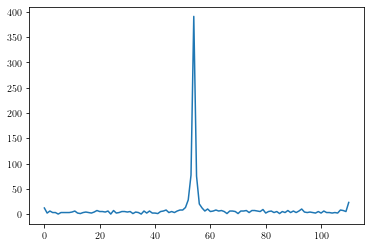

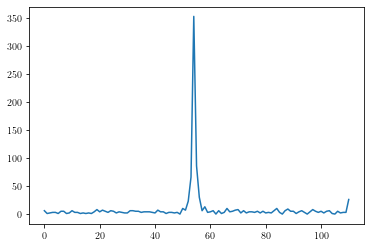

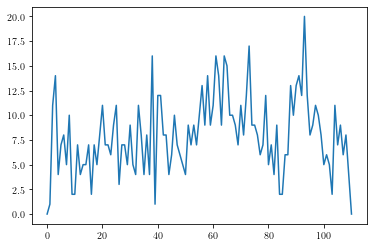

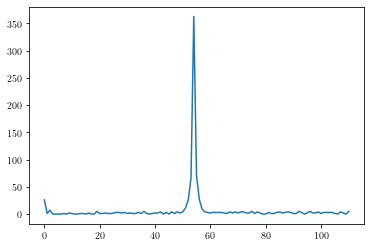

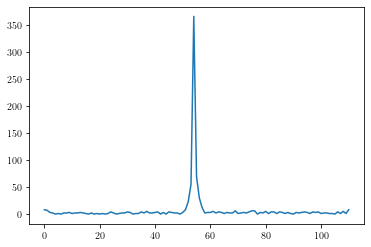

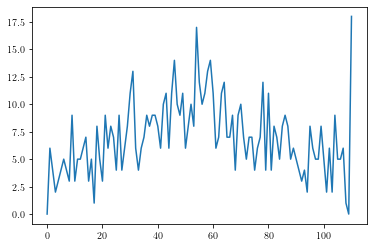

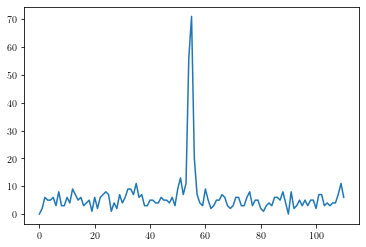

In [35]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [36]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)